In [1]:
import math
import numpy as np
import sys
#import cv2
import pickle
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [3]:
input_filename = "data/LAMP_80s_240mpp_ratio_albed_01.img"
shape = (2501, 2501) # matrix size
dtype = np.float32 # big-endian unsigned integer (16bit)
output_filename = "LAMP_BRITE.PNG"

In [4]:
height = np.reshape(np.fromfile(open("data/LDEM_75S_120M.IMG",
                                     'rb'), np.int16),
                    (7624,7624))
albedo = np.reshape(np.fromfile(open("data/LDAM_50S_1000M_FLOAT.IMG",
                                     'rb'), np.float32),
                    (2532,2532))
LAMP_ratio_albed = np.reshape(np.fromfile(open("data/LAMP_80s_240mpp_ratio_albed_01.img",
                                     'rb'), np.float32),
                    (2501,2501))
LAMP_ratio_brite = np.reshape(np.fromfile(open("data/LAMP_80s_240mpp_ratio_brite_01.img",
                                     'rb'), np.float32),
                    (2501,2501))

In [5]:
import cv2

height = height[1311:-1311,1311:-1311]
albedo = albedo[966:-966,966:-966]

#height = cv2.resize(height, dsize=LAMP_ratio_albed.shape)
lamp_brite = cv2.resize(LAMP_ratio_brite, dsize=height.shape)
lamp_albed = cv2.resize(LAMP_ratio_albed, dsize=height.shape)
albedo = cv2.resize(albedo, dsize=height.shape)

In [22]:
threshold_albedo = 0.35
threshold_lamp_ratio = 1.2

In [23]:
image = albedo > threshold_albedo

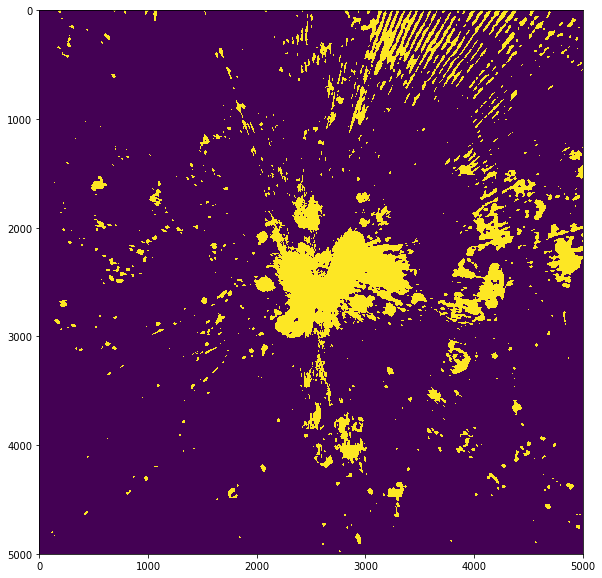

In [24]:
plt.imshow(image)
plt.savefig(output_filename)
plt.show()

In [25]:
POI = ((lamp_albed > threshold_lamp_ratio) & 
        (lamp_brite > threshold_lamp_ratio) & 
        (albedo > threshold_albedo))

/home/georgesmss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [26]:
top_left = (1500,450)
bottom_right = (top_left[0] + 200, top_left[1] + 200)

In [27]:
POI2 = POI * 200

In [28]:
POI3 = POI2
POI3[top_left[0]:top_left[0]+10,top_left[1]:bottom_right[1]] = 255 #upper bar
POI3[bottom_right[0]:bottom_right[0]+10,top_left[1]:bottom_right[1]] = 255 #lower bar
POI3[top_left[0]:bottom_right[0],top_left[1]:top_left[1]+10] = 255 #to the left
POI3[top_left[0]:bottom_right[0],bottom_right[1]:bottom_right[1]+10] = 255 #to the right

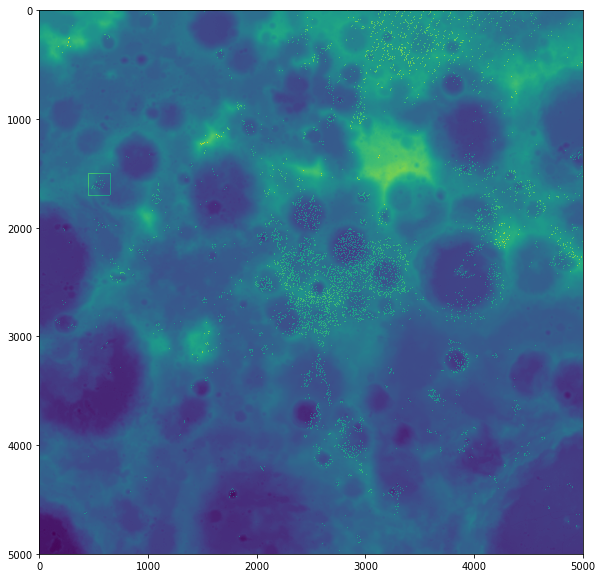

In [56]:
plt.imshow(40*POI3 + height)
plt.savefig("agua_no_polo_sul_da_lua_uau.png")
plt.show()

# Optimization Step

In [85]:
m_per_px = 120
rover_max_dist_m = 24000
rover_max_dist_px = int(rover_max_dist_m / m_per_px) + 1

In [86]:
POI_little = POI[top_left[0]:top_left[0]+rover_max_dist_px,
                top_left[1]:top_left[1]+rover_max_dist_px]
POI_little.shape

(201, 201)

In [32]:
height_little = height[top_left[0]:top_left[0]+rover_max_dist_px,
                        top_left[1]:top_left[1]+rover_max_dist_px]
height_little.shape

(201, 201)

In [33]:
import copy

In [34]:
POI_little_filter = copy.deepcopy(POI_little)

In [35]:
for i in range(2,rover_max_dist_px-2):
    for j in range(2,rover_max_dist_px-2):
        POI_little_filter[i,j] =(
                                POI_little[i-1,j-1] & POI_little[i-1,j] & POI_little[i-1,j+1] & 
                                POI_little[i,j-1] & POI_little[i,j] & POI_little[i,j+1] & 
                                POI_little[i+1,j-1] & POI_little[i+1,j] & POI_little[i+1,j+1])
        
                            

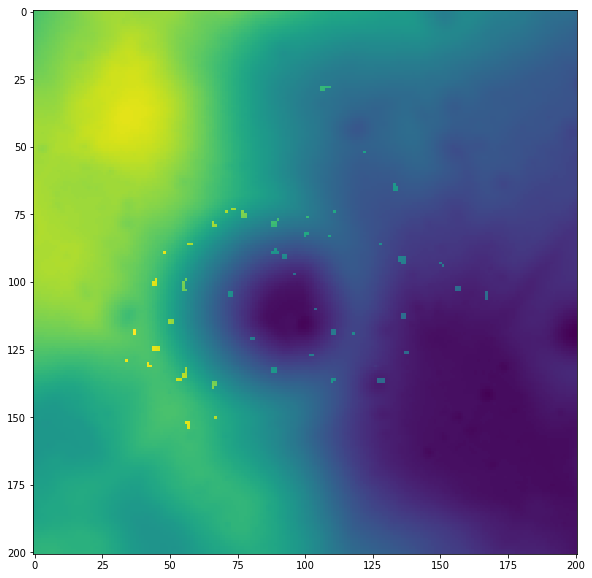

In [36]:
plt.imshow(height_little+2000*POI_little_filter)

In [91]:
int((rover_max_dist_px-1) / 2)

100

In [110]:
coord_of_POI = [(int((rover_max_dist_px-1) / 2),int((rover_max_dist_px-1) / 2))]
for i in np.arange(rover_max_dist_px):
    for j in np.arange(rover_max_dist_px):
        if POI_little_filter[i,j]:
            coord_of_POI.append((i,j))

coord_of_POI = np.array(coord_of_POI)
np.savetxt("routing_files/coord_of_POI.csv", coord_of_POI, delimiter=',', fmt='%f')

In [111]:
n_POI = len(coord_of_POI)

euclidean_distances = np.zeros((n_POI,n_POI))

for i in range(n_POI):
    for j in range(i+1,n_POI):
        distance = math.sqrt(((coord_of_POI[i][0]-coord_of_POI[j][0])**2) +
                        ((coord_of_POI[i][1]-coord_of_POI[j][1])**2))
        #print(i, list_of_POI[i], j,list_of_POI[j],distance)
        euclidean_distances[i,j] = distance
        euclidean_distances[j,i] = distance
np.savetxt("routing_files/euclidean_distances.csv", euclidean_distances, delimiter=',', fmt='%f')

In [130]:
from sklearn.cluster import KMeans

k=math.ceil(len(coord_of_POI)/30)

kmeans = KMeans(n_clusters=k, random_state=0).fit(coord_of_POI[1:])

In [131]:
clusters = kmeans.labels_ 
np.savetxt("routing_files/clusters.csv", clusters, delimiter=',', fmt='%f')

In [132]:
centers = kmeans.cluster_centers_
np.savetxt("routing_files/centers.csv", centers, delimiter=',', fmt='%f')

In [159]:
import networkx as nx

In [160]:
G=nx.DiGraph()

In [161]:
for i in np.arange(rover_max_dist_px):
    for j in np.arange(rover_max_dist_px):
        G.add_node((i,j))

In [ ]:
def weight_linear(i1, j1, i2, j2):
    height1 = height_little[i1,j1]
    height2 = height_little[i2,j2]
    delta = abs


def weight_diagonal(i1, j1, i2, j2):

In [ ]:
for i in np.arange(rover_max_dist_px) - math.floor(rover_max_dist_px/2):
    for j in np.arange(rover_max_dist_px) - math.floor(rover_max_dist_px/2):
        G.add_edge((i,j),(i,j+1), weight=  )
        G.add_edge((i,j+1),(i,j), "distance" = )
        G.add_edge((i,j),(i+1,j+1), "distance" = )
        G.add_edge((i+1,j+1),(i,j), "distance" = )
        G.add_edge((i,j),(i+1,j), "distance" = )
        G.add_edge((i+1,j),(i,j), "distance" = )

In [35]:
G.add_nodes_from([(1,1), (1,2), (2,1), (2,2)])

In [37]:
G.node[(1,1)].

{}

In [ ]:
G.add_edge(1, 2)
e = (2, 3)
G.add_edge(*e)  # unpack edge tuple*

In [ ]:
G = nx.path_graph(5)
path = nx.single_source_shortest_path(G, 0)
path[4]